<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1aS4vX-ucDKBmZmZMrBwgjl_DvLAadX2C" width=900/></p>


<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. RAG.

В этом домашнем задании вам предстоит создать туристический RAG, провести EDA и проявить креатив! :)

Вам дан набор данных, содержащий информацию о памятниках, архитектуре и других значимых местах. В данных есть:
* название достопримечательности;
* идентификатор на WikiData;
* город расположения;
* координаты долготы и широты;
* описание (извлеченное из WikiData);
* изображение в формате base64;
* сгенерированное описание изображения (генерация с помощью модели BLIP).

Некоторые из памятников могут встречаться несколько раз, но с различными изображениями, из которых не все могут быть качественными. Для компенсации этого даны текстовые описания.

Часть данных взята с Национальной технологической олимпиады студентов по CV. Базовое решение предполагает использование мультимодального ru-CLIP. Но в данном домашнем задании предлагается решить эту задачу творчески, используя NLP подход.

## Установка и импорт библиотек

In [1]:
# pip install -q gdown torch transformers==4.49 accelerate bitsandbytes langchain-chroma sentence-transformers faiss-cpu openpyxl datasets langchain-community ragatouille umap-learn matplotlib plotly sentencepiece pymorphy2

In [42]:
!pip install -q gdown torch gcsfs jedi fsspec transformers==4.49 pandas numpy accelerate bitsandbytes  sentence-transformers faiss-cpu openpyxl datasets langchain-community ragatouille umap-learn pymorphy3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 32.3 MB/s eta 0:00:00


In [13]:
from platform import python_version

print(python_version())

3.11.12


In [43]:
import gdown
import os
import random
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Optional, List, Tuple, Union
import matplotlib.pyplot as plt

import base64
import requests
from PIL import Image
import PIL
from io import BytesIO

import re
import string
import nltk
import pymorphy3
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

import torch
from transformers import pipeline
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from sentence_transformers import SentenceTransformer

from langchain.docstore.document import Document as LangchainDocument
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from ragatouille import RAGPretrainedModel
from transformers import Pipeline

from sklearn.decomposition import PCA
import umap

import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
!nvidia-smi
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

/bin/bash: line 1: nvidia-smi: command not found


'cpu'

In [16]:
SEED = 42

def seed_torch(seed:int=42):
    """
    Функция для фиксации воспроизведения расчетов
        seed:int - параметр фиксации
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [17]:
seed_torch(SEED)

## Загрузка данных (4 балла)

In [20]:
NEED_DOWNLOAD = True
if NEED_DOWNLOAD:
  url = 'https://drive.google.com/file/d/1ig5jbqm1GddmFkv_G9Dqb6kLOEKKE0Bh/view?usp=sharing'
  output = 'file.csv'

  gdown.download(url, output, quiet=False)
else:
  print('Данные загружены')

Downloading...
From (original): https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk
From (redirected): https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk&confirm=t&uuid=ebc7597b-5037-46a5-9e81-da01ff2f7260
To: /content/file.csv
100%|██████████| 672M/672M [00:12<00:00, 54.4MB/s]


In [21]:
data_orig = pd.read_csv('file.csv')
print(data_orig.shape)
data_orig.head(2)

(14634, 9)


,Unnamed: 0,Name,WikiData,City,Lon,Lat,description,image,en_txt
0,0,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there are two people that are standing on a tr...
1,1,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed building with a blue and white exterior...


Для декодирования изображений, закодированных в формате base64, можно использовать следующий код:

In [22]:
def get_image(data):

    image = Image.open(BytesIO(base64.b64decode(data))).convert('RGB')
    return image

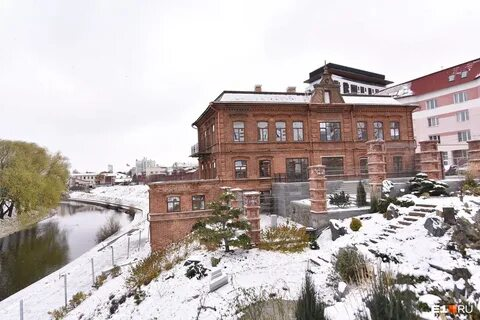

In [23]:
get_image(data_orig.sample(1)['image'].tolist()[0])

В данных есть выбросы — записи, не относящихся к туристическим или историческим объектам. Для очистки данных можно, например, использовать алгоритм TF-IDF: создаем корпус текстов из описаний, применяем TF-IDF, извлекаем наиболее редко или часто встречающиеся слова. Они могут указывать на мусорные данные, такие как мемы, баннеры или личные фото людей. После выделения подозрительных паттернов, можно провести ручную проверку и фильтрацию данных.

Для дальнейшего тестирования и получения чистых сэмплов, рекомендуется взять не менее 100 чистых образцов со стратификацией по городу и названию места. Это можно сделать, выбрав случайным образом несколько образцов из каждой категории (город + название места), чтобы обеспечить равномерное представительство и разнообразие данных.

**!! Важно:** Помните, что чистые сэмплы одного и того же места выдадут примерно одинаковое описание. Есть несколько стратегий, как повысить разнообразие ответов:

- выбор одного самого лучшего:
  - самое длинное описание
  - смое подходящие по мнению LLM
- конкатенация описаний (но важно не сконкатенировать слишком много)

Изображения можно отдать в мета-данные.

In [24]:
data_orig.columns

Index(['Unnamed: 0', 'Name', 'WikiData', 'City', 'Lon', 'Lat', 'description',
       'image', 'en_txt'],
      dtype='object')

In [25]:
need_cols = ['Name', 'City', 'description', 'image', 'en_txt']
data_orig = data_orig[need_cols]
print(data_orig.shape)
data_orig.head()

(14634, 5)


,Name,City,description,image,en_txt
0,Динамо,Екатеринбург,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there are two people that are standing on a tr...
1,Динамо,Екатеринбург,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed building with a blue and white exterior...
2,Динамо,Екатеринбург,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
3,Динамо,Екатеринбург,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
4,Динамо,Екатеринбург,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a boat that is in the water near a bu...


In [26]:
display(data_orig.nunique(), data_orig.describe())

,0
Name,387
City,4
description,245
image,13281
en_txt,10154


,Name,City,description,image,en_txt
count,14634,14634,12078,14634,14634
unique,387,4,245,13281,10154
top,Владимир,Ярославль,Православный храм в Ярославле,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAICAgICAQICAg...,arafed view of a large white building with gol...
freq,114,4372,605,10,83


In [27]:
data = data_orig.groupby(['Name', 'City', 'description']).agg({'image': set, 'en_txt': set}).reset_index()
print(data.shape)
data.head()

(320, 5)


,Name,City,description,image,en_txt
0,Cerkiew Narodzenia Pańskiego w Jarosławiu,Ярославль,Православный храм в Ярославле,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed wooden church with a steeple and a ste...
1,Cerkiew Włodzimierskiej Ikony Matki Bożej w Ja...,Ярославль,Архитектурный ансамбль в Ярославле,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed wooden church with a steeple and a ste...
2,Cerkiew św. Dymitra Sołuńskiego w Jarosławiu,Ярославль,Церковь великомученика Димитрия Солунского (См...,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed wooden church with a steeple and a ste...
3,église arménienne de Vladimir,Владимир,Армянская церковь в г. Владимир России,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed man in a brown jacket eating a meal at...
4,Авиамеханический колледж,Владимир,Владимирский авиамеханический колледж,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{students sitting at desks in a classroom with...


In [28]:
list(data['en_txt'][0])

['arafed wooden church with a steeple and a steeple on the roof',
 'there is a small church with two steeples on the roof',
 'there is a wooden church with two steeples on top of it',
 'arafed wooden church with steeple and steeple on top',
 'arafed wooden building with a steeple and a roof',
 'there is a wooden building with a wooden fence and a wooden fence',
 'arafed view of a white building with a green dome',
 'there are two wooden buildings with flags on the fence',
 'there are two wooden buildings in the middle of a field',
 'there is a wooden building with a steeple on the top',
 'there is a small wooden building with a steeple on top',
 'arafed church with a green roof and a steeple',
 'arafed building with a green roof and a green dome',
 'arafed church with a steeple and a steeple on the roof',
 'arafed wooden church with a steeple and a blue roof',
 'there is a large wooden building with a steeple on top',
 'arafed wooden building with a steeple and a steeple on the top',
 

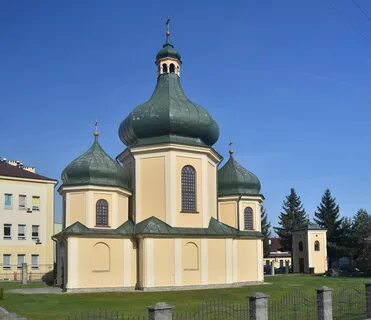

In [29]:
get_image(list(data['image'][0])[0])

In [30]:
print(f'Количество уникальных городов: {data.City.nunique()}')
data.City.value_counts()

Количество уникальных городов: 4


,count
City,
Нижний Новгород,98
Екатеринбург,97
Ярославль,96
Владимир,29


In [31]:
data.isna().mean()

,0
Name,0.0
City,0.0
description,0.0
image,0.0
en_txt,0.0


In [32]:
for i in need_cols:
    data[f'len_{i}'] = data[i].apply(lambda x: len(str(x)))
display(data.describe())

,len_Name,len_City,len_description,len_image,len_en_txt
count,320.000000,320.000000,320.000000,3.200000e+02,320.000000
mean,26.537500,11.656250,33.290625,1.714635e+06,2039.503125
std,12.935765,2.609476,21.594436,5.490707e+05,658.010552
min,4.000000,8.000000,5.000000,9.640800e+05,991.000000
25%,18.000000,9.000000,22.000000,1.307805e+06,1621.750000
50%,25.000000,12.000000,29.000000,1.510466e+06,1755.500000
75%,32.000000,15.000000,38.000000,1.989991e+06,2448.750000
max,76.000000,15.000000,225.000000,3.320324e+06,3785.000000


In [33]:
data.groupby('description').Name.count().sort_values(ascending=False).reset_index().head()

,description,Name
0,Православный храм в Ярославле,13
1,здание в Екатеринбурге,10
2,круглая башня Нижегородского кремля,8
3,музей в Екатеринбурге,8
4,памятник в Екатеринбурге,4


In [34]:
# Загрузка предтренировочной модели для машинного перевода

MODEL_TRANS_NAME = "facebook/mbart-large-50-many-to-many-mmt"
SRC_LANG = "ru_RU"  # Код языка для русского
TRG_LANG = "en_XX"   # Код языка для английского

# Функция для перевода текста
def translate(model_trans,
              tokenizer_trans,
              text:str,
              src:str=SRC_LANG,
              dest:str=TRG_LANG):
    """
    Функция для перевода текста
        model_trans - предобученная модель машинного перевода
        tokenizer_trans - токенизатор модели
        text:str - текст для перевода
        src:str - код языка с которого необходимо перевести
        dest:str - код языка на который необходимо перевести
    """
    tokenizer_trans.src_lang = src
    encoded_input = tokenizer_trans(text, return_tensors="pt").to(DEVICE)


    generated_tokens = model_trans.generate(**encoded_input, forced_bos_token_id=tokenizer_trans.lang_code_to_id[dest])

    return tokenizer_trans.batch_decode(generated_tokens, skip_special_tokens=True)[0]


try:
    MODEL_TRANS = MBartForConditionalGeneration.from_pretrained(MODEL_TRANS_NAME).to(DEVICE)
    TOKENIZER_TRANS = MBart50TokenizerFast.from_pretrained(MODEL_TRANS_NAME)
    print(f"Модель и токенизатор загружены успешно!")
except Exception as e:
    print(f"Ошибка при загрузке: {e}")

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

Модель и токенизатор загружены успешно!


In [35]:
# Проверка кода
source_text = data['description'][0] # первое описние из датасета
translated_text = translate(MODEL_TRANS, TOKENIZER_TRANS, source_text)
print(f'На русском: {source_text} \nНа английском: {translated_text}')

На русском: Православный храм в Ярославле 
На английском: Orthodox Church in Yaroslavl


In [36]:
%%time

ru_corpus = set(data.description)
trans_ru_to_en = {k:v for k, v in zip(ru_corpus, [translate(model_trans=MODEL_TRANS,
                                                            tokenizer_trans=TOKENIZER_TRANS,
                                                            text=x) for i, x in tqdm(enumerate(ru_corpus))])}
data['en_description'] = data['description'].map(trans_ru_to_en)

0it [00:00, ?it/s]

CPU times: user 24min 37s, sys: 6.55 s, total: 24min 44s
Wall time: 23min 48s


In [37]:
need_cols = ['Name', 'City', 'description', 'image', 'en_txt', 'en_description']
data_filterd = data[need_cols].copy()
print(data_filterd.shape)
data_filterd.head()

(320, 6)


,Name,City,description,image,en_txt,en_description
0,Cerkiew Narodzenia Pańskiego w Jarosławiu,Ярославль,Православный храм в Ярославле,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed wooden church with a steeple and a ste...,Orthodox Church in Yaroslavl
1,Cerkiew Włodzimierskiej Ikony Matki Bożej w Ja...,Ярославль,Архитектурный ансамбль в Ярославле,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed wooden church with a steeple and a ste...,Architectural ensemble in Yaroslavl
2,Cerkiew św. Dymitra Sołuńskiego w Jarosławiu,Ярославль,Церковь великомученика Димитрия Солунского (См...,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed wooden church with a steeple and a ste...,Church of St. Demetrius of Alexandria (Smolens...
3,église arménienne de Vladimir,Владимир,Армянская церковь в г. Владимир России,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed man in a brown jacket eating a meal at...,"Armenian Church in Vladimir, Russia"
4,Авиамеханический колледж,Владимир,Владимирский авиамеханический колледж,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{students sitting at desks in a classroom with...,Vladimir Aviation Mechanical College


In [44]:
ENG_STOP_WORDS = list(set(stopwords.words('english')))
RUS_STOP_WORDS = list(set(stopwords.words('russian')))
STOP_WORDS = ENG_STOP_WORDS + RUS_STOP_WORDS
STOP_WORDS.append('none')
PUNCT_WORD_TOKENIZER = nltk.WordPunctTokenizer()
MORPH_ANALYZER = pymorphy3.MorphAnalyzer()

def preprocess_text(text, norm_tokens: bool=True, stopwords: set=(), del_ru: bool=True):
    """
    Функция предобработки текста
        text - текст
        norm_tokens - флаг нормализации текста
        stopwords - стопслова
        del_ru - необходимость удалять русские слова или наоборот
    """
    nums_filtered_text = re.sub(r'[0-9]+', '', text.lower())
    if del_ru:
        word_filtered_text = re.sub(r'[^a-zA-Z\s]+', '', nums_filtered_text)
    else:
        word_filtered_text = re.sub(r'[a-zA-Z]+', '', nums_filtered_text)
    punct_filtered_text = ''.join([ch for ch in word_filtered_text if ch
                                   not in string.punctuation])
    tokens = PUNCT_WORD_TOKENIZER.tokenize(punct_filtered_text)
    if len(stopwords) != 0:
      tokens = [MORPH_ANALYZER.parse(token)[0].normal_form for token in tokens
                if token not in stopwords]
    if norm_tokens:
        tokens = [MORPH_ANALYZER.parse(token)[0].normal_form for token in tokens]

    return ' '.join(tokens)


def unique_words(text):
    """
    Функция извлечения уникальных слов из текста
        text - текст
    """
    words = text.split()
    unique_words = list(set(words))
    return ' '.join(unique_words)

In [45]:
data_filterd['image'] = data_filterd.image.apply(lambda x: list(x))
data_filterd['all_en_txt'] = data_filterd.en_txt.apply(lambda x: ' '.join(list(x)))
data_filterd['all_en_txt'] = data_filterd[['en_description', 'all_en_txt']].apply(lambda x: ' '.join(x), axis=1)

data_filterd['processed_text'] = (data_filterd['all_en_txt']
                                  .apply(lambda x: preprocess_text(text=x
                                                                   , norm_tokens = True
                                                                   , stopwords=STOP_WORDS
                                                                   )
                                         )
                                  )

data_filterd['unique_processed_text'] = (data_filterd['processed_text']
                                         .apply(lambda x: unique_words(text=x)
                                                )
                                         )

print(data_filterd.shape)
data_filterd.head(2)

(320, 9)


,Name,City,description,image,en_txt,en_description,all_en_txt,processed_text,unique_processed_text
0,Cerkiew Narodzenia Pańskiego w Jarosławiu,Ярославль,Православный храм в Ярославле,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed wooden church with a steeple and a ste...,Orthodox Church in Yaroslavl,Orthodox Church in Yaroslavl arafed wooden chu...,orthodox church yaroslavl arafed wooden church...,dome orthodox blue crosses steeples flags larg...
1,Cerkiew Włodzimierskiej Ikony Matki Bożej w Ja...,Ярославль,Архитектурный ансамбль в Ярославле,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed wooden church with a steeple and a ste...,Architectural ensemble in Yaroslavl,Architectural ensemble in Yaroslavl arafed woo...,architectural ensemble yaroslavl arafed wooden...,snow roofing hill angels people chandelier rid...


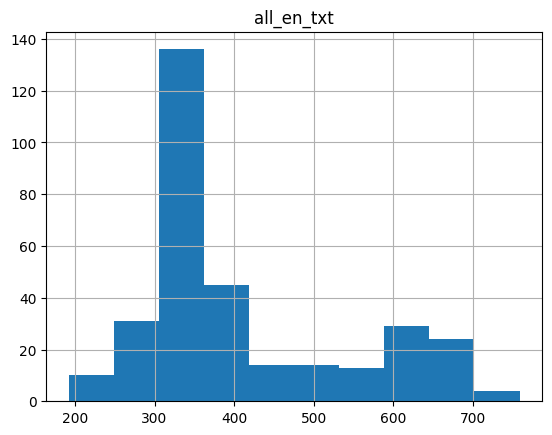

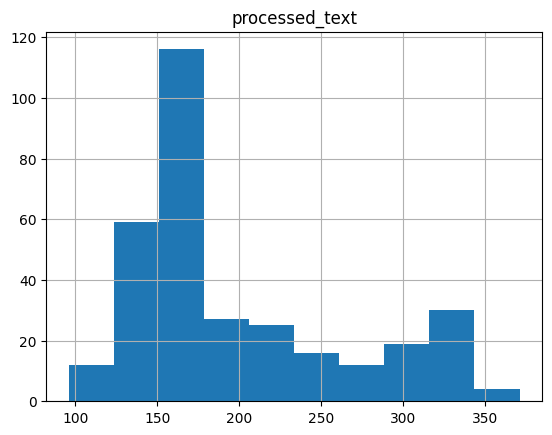

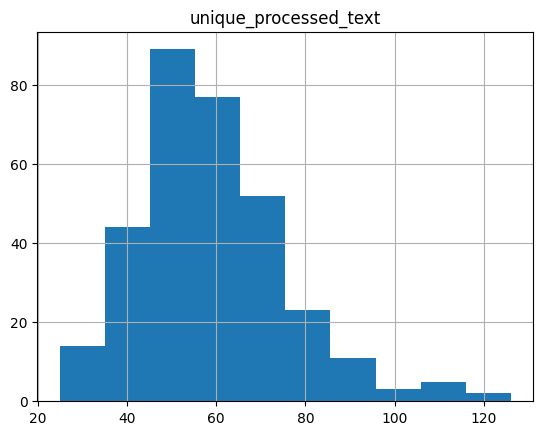

,num_tokens_of_all_en_txt,num_tokens_of_processed_text,num_tokens_of_unique_processed_text
count,320.00000,320.000000,320.000000
mean,410.14375,198.193750,59.484375
std,129.83099,65.650351,16.532283
min,192.00000,96.000000,25.000000
25%,324.00000,153.000000,49.000000
50%,356.00000,170.000000,57.000000
75%,488.75000,234.000000,69.000000
max,759.00000,371.000000,126.000000


In [46]:
for i in ['all_en_txt', 'processed_text', 'unique_processed_text']:
    data_filterd[f'num_tokens_of_{i}'] = data_filterd[i].apply(lambda x: len(PUNCT_WORD_TOKENIZER.tokenize(x)))
    data_filterd[f'num_tokens_of_{i}'].hist()
    plt.title(i)
    plt.show()
data_filterd.describe()

In [47]:
corpus_txt = data_filterd.unique_processed_text.tolist()

vectorizer = TfidfVectorizer(ngram_range=(1,2))

# Применение TF-IDF к текстовым данным
matrix = vectorizer.fit_transform(corpus_txt)
feature_names = vectorizer.get_feature_names_out()

all_score_df = (pd.DataFrame({'word': feature_names,
                              'score': matrix.toarray().sum(axis=0)})
                .sort_values('score')).reset_index(drop=True)
all_score_df

,word,score
0,wheel pole,0.078593
1,cake ties,0.078593
2,gear,0.078593
3,shirt facade,0.078593
4,operate large,0.078593
...,...,...
9398,top,7.669495
9399,building,7.686770
9400,large,7.691939
9401,tower,7.716706


In [48]:
def show_contains(df: pd.DataFrame,
                  column: str,
                  word: str):
    """
    Функция отображения контекта по входящему выражения
        df - датафрейм
        column - столбец, по которому проверяем вхождение
        word - слово / предложение, которое проверяем в column
    """

    df = df[df[column].str.contains(word)]
    name = df.Name.values[0]
    len_images = len(df['image'].values[0])

    display(df.head(3),
            print(f'Наименование объекта: {name}, количество картинок: {len_images}'),
        get_image(df['image'].values[0][np.random.randint(0,len_images)]))

Наименование объекта: Автомеханический техникум, количество картинок: 56


,Name,City,description,image,en_txt,en_description,all_en_txt,processed_text,unique_processed_text,num_tokens_of_all_en_txt,num_tokens_of_processed_text,num_tokens_of_unique_processed_text
6,Автомеханический техникум,Ярославль,образовательное учреждение в Ярославле,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{there are many people in a classroom with man...,educational institution in Yaroslavl,educational institution in Yaroslavl there are...,educational institution yaroslavl many people ...,boys door papers court using cars row transpor...,624,306,126


None

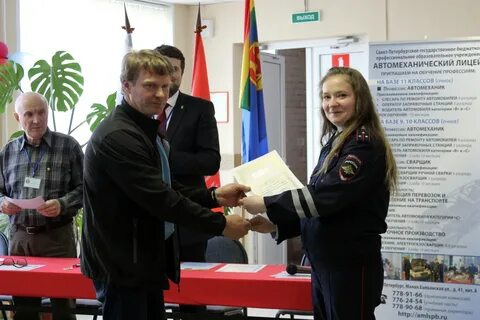

In [49]:
show_contains(data_filterd, 'unique_processed_text', all_score_df['word'][0])

Наименование объекта: Автомеханический техникум, количество картинок: 56


,Name,City,description,image,en_txt,en_description,all_en_txt,processed_text,unique_processed_text,num_tokens_of_all_en_txt,num_tokens_of_processed_text,num_tokens_of_unique_processed_text
6,Автомеханический техникум,Ярославль,образовательное учреждение в Ярославле,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{there are many people in a classroom with man...,educational institution in Yaroslavl,educational institution in Yaroslavl there are...,educational institution yaroslavl many people ...,boys door papers court using cars row transpor...,624,306,126


None

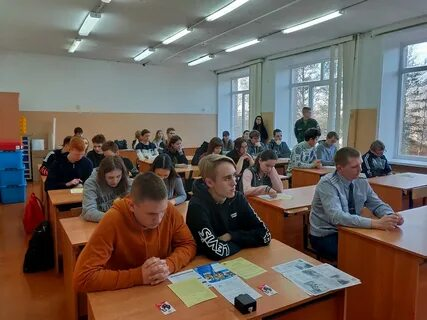

In [50]:
show_contains(data_filterd, 'unique_processed_text', all_score_df['word'][1])

Наименование объекта: Cerkiew Włodzimierskiej Ikony Matki Bożej w Jarosławiu, количество картинок: 59


,Name,City,description,image,en_txt,en_description,all_en_txt,processed_text,unique_processed_text,num_tokens_of_all_en_txt,num_tokens_of_processed_text,num_tokens_of_unique_processed_text
1,Cerkiew Włodzimierskiej Ikony Matki Bożej w Ja...,Ярославль,Архитектурный ансамбль в Ярославле,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed wooden church with a steeple and a ste...,Architectural ensemble in Yaroslavl,Architectural ensemble in Yaroslavl arafed woo...,architectural ensemble yaroslavl arafed wooden...,snow roofing hill angels people chandelier rid...,653,322,96
2,Cerkiew św. Dymitra Sołuńskiego w Jarosławiu,Ярославль,Церковь великомученика Димитрия Солунского (См...,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed wooden church with a steeple and a ste...,Church of St. Demetrius of Alexandria (Smolens...,Church of St. Demetrius of Alexandria (Smolens...,church st demetrius alexandria smolensk yarosl...,landscape hill people chandelier riding weddin...,644,304,77
3,église arménienne de Vladimir,Владимир,Армянская церковь в г. Владимир России,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed man in a brown jacket eating a meal at...,"Armenian Church in Vladimir, Russia","Armenian Church in Vladimir, Russia arafed man...",armenian church vladimir russia arafed man bro...,generated landscape planets rendering dome sta...,362,164,75


None

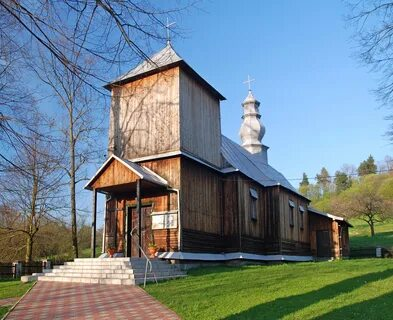

In [51]:
show_contains(data_filterd, 'unique_processed_text', all_score_df['word'].iloc[-1])

In [52]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),
                             min_df=0.1)

# Применение TF-IDF к текстовым данным
matrix = vectorizer.fit_transform(corpus_txt)
feature_names = vectorizer.get_feature_names_out()

need_score_df = (pd.DataFrame({'word': feature_names,
                               'score': matrix.toarray().sum(axis=0)})
                 .sort_values('score'))
need_score_df

,word,score
176,walking photo,6.234021
13,bell,6.413263
185,windows city,6.417854
111,painting snowy,6.434347
29,carriage,6.437070
...,...,...
39,clock,20.347968
85,large,20.586827
64,front,20.695157
21,building,20.810879


In [53]:
def choose_optimal_k_elbow(data, min_k: int=4, devide: int=10, step: int=100):
    """
    Функция определения оптимального количества кластеров по метрикам kmeans_score и silhouette
        data - датафрейм / матрица
        min_k - минимальное количество кластеров
        devide - значение делитель размера датафрейма
        step - шаг добавления кластеров
    """
    k_scores = []
    s_scores = []

    k_max = int(data.shape[0]/devide)

    k_values = range(min_k, k_max, step)

    for k in tqdm(k_values):
        kmeans = KMeans(n_clusters=k,
                        init='k-means++',
                        n_init=10,
                        max_iter=300,
                        tol=0.0001,
                        random_state=42)

        preds = kmeans.fit_predict(data)

        k_scores.append(-kmeans.score(data))

        # Silhouette Score
        silhouette = silhouette_score(data, preds)
        s_scores.append(silhouette)

    plt.plot(k_values, k_scores, marker='o')
    plt.title('Метод локтя')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Значение метрики')
    plt.show()

    plt.plot(k_values, s_scores, marker='o')
    plt.title('Метрика Silhouette KMeans модели при разном значении размера кластера')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Значение метрики')
    plt.show()

  0%|          | 0/17 [00:00<?, ?it/s]

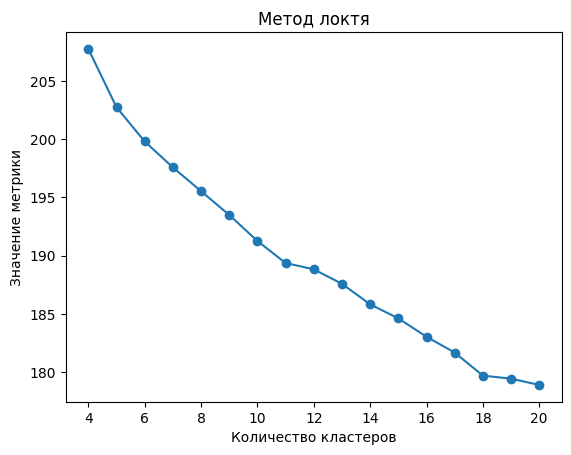

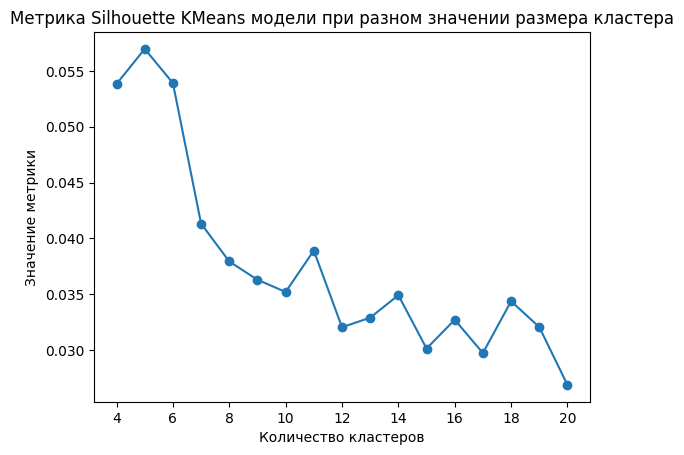

In [54]:
choose_optimal_k_elbow(matrix, devide=15, step=1)

In [55]:
km_clustering = KMeans(
    n_clusters=6,
    init='k-means++',
    n_init=10,
    max_iter=300,
    tol=0.0001)

data_filterd['prediction'] = km_clustering.fit_predict(matrix)
prediction_counts = (data_filterd['prediction']
                     .value_counts()
                     .sort_values()
                     .reset_index()
                     .rename(columns={'count':'v_counts'})
                    )
prediction_counts.head()

,prediction,v_counts
0,4,25
1,1,37
2,3,37
3,0,58
4,2,65


In [56]:
prediction_counts.describe()

,prediction,v_counts
count,6.000000,6.000000
mean,2.500000,53.333333
std,1.870829,26.417166
min,0.000000,25.000000
25%,1.250000,37.000000
50%,2.500000,47.500000
75%,3.750000,63.250000
max,5.000000,98.000000


In [57]:
# 10% кластеров по value_counts и сортировке
need_clusters = (prediction_counts[prediction_counts['v_counts']
                 >=prediction_counts['v_counts'].quantile(0.1)]
                 .prediction)

# Посмотрим как меняется количество наблюдений после фильтрации
print(data_filterd.shape,
      data_filterd[data_filterd['prediction'].isin(need_clusters)].shape)

(320, 13) (295, 13)


In [58]:
(
    data_filterd.City.value_counts(),
    data_filterd[data_filterd['prediction'].isin(need_clusters)].City.value_counts())

(City
 Нижний Новгород    98
 Екатеринбург       97
 Ярославль          96
 Владимир           29
 Name: count, dtype: int64,
 City
 Екатеринбург       94
 Ярославль          93
 Нижний Новгород    80
 Владимир           28
 Name: count, dtype: int64)

In [59]:
data_filterd = data_filterd[data_filterd['prediction'].isin(need_clusters)]
print(data_filterd.shape)
data_filterd.head()

(295, 13)


,Name,City,description,image,en_txt,en_description,all_en_txt,processed_text,unique_processed_text,num_tokens_of_all_en_txt,num_tokens_of_processed_text,num_tokens_of_unique_processed_text,prediction
0,Cerkiew Narodzenia Pańskiego w Jarosławiu,Ярославль,Православный храм в Ярославле,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed wooden church with a steeple and a ste...,Orthodox Church in Yaroslavl,Orthodox Church in Yaroslavl arafed wooden chu...,orthodox church yaroslavl arafed wooden church...,dome orthodox blue crosses steeples flags larg...,265,130,30,5
1,Cerkiew Włodzimierskiej Ikony Matki Bożej w Ja...,Ярославль,Архитектурный ансамбль в Ярославле,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed wooden church with a steeple and a ste...,Architectural ensemble in Yaroslavl,Architectural ensemble in Yaroslavl arafed woo...,architectural ensemble yaroslavl arafed wooden...,snow roofing hill angels people chandelier rid...,653,322,96,5
2,Cerkiew św. Dymitra Sołuńskiego w Jarosławiu,Ярославль,Церковь великомученика Димитрия Солунского (См...,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed wooden church with a steeple and a ste...,Church of St. Demetrius of Alexandria (Smolens...,Church of St. Demetrius of Alexandria (Smolens...,church st demetrius alexandria smolensk yarosl...,landscape hill people chandelier riding weddin...,644,304,77,5
3,église arménienne de Vladimir,Владимир,Армянская церковь в г. Владимир России,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed man in a brown jacket eating a meal at...,"Armenian Church in Vladimir, Russia","Armenian Church in Vladimir, Russia arafed man...",armenian church vladimir russia arafed man bro...,generated landscape planets rendering dome sta...,362,164,75,5
4,Авиамеханический колледж,Владимир,Владимирский авиамеханический колледж,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{students sitting at desks in a classroom with...,Vladimir Aviation Mechanical College,Vladimir Aviation Mechanical College students ...,vladimir aviation mechanical college students ...,state driving buses papers parked cars close b...,343,167,64,0


In [60]:
data_filterd.City.value_counts()

,count
City,
Екатеринбург,94
Ярославль,93
Нижний Новгород,80
Владимир,28


In [61]:
data_filterd.City.value_counts()

,count
City,
Екатеринбург,94
Ярославль,93
Нижний Новгород,80
Владимир,28


In [62]:
for i in ['Name', 'City', 'description']:
    data_filterd[f'len_{i}'] = data_filterd[i].apply(lambda x: len(str(x)))
display(data_filterd.describe())

,num_tokens_of_all_en_txt,num_tokens_of_processed_text,num_tokens_of_unique_processed_text,prediction,len_Name,len_City,len_description
count,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000
mean,410.877966,198.366102,60.061017,2.603390,27.142373,11.488136,33.047458
std,128.840639,65.582281,16.627870,1.917159,13.182397,2.560631,22.192213
min,192.000000,96.000000,25.000000,0.000000,4.000000,8.000000,5.000000
25%,327.000000,153.500000,50.000000,1.000000,18.000000,9.000000,21.000000
50%,358.000000,170.000000,57.000000,2.000000,25.000000,12.000000,29.000000
75%,485.500000,233.500000,69.000000,5.000000,32.000000,15.000000,38.000000
max,759.000000,371.000000,126.000000,5.000000,76.000000,15.000000,225.000000


In [63]:
data_filterd[data_filterd.len_description==5]

,Name,City,description,image,en_txt,en_description,all_en_txt,processed_text,unique_processed_text,num_tokens_of_all_en_txt,num_tokens_of_processed_text,num_tokens_of_unique_processed_text,prediction,len_Name,len_City,len_description
130,Литературная жизнь Урала XX века,Екатеринбург,Музей,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{there is a small house with a porch and a cov...,Museum,Museum there is a small house with a porch and...,museum small house porch covered patio red bac...,picture parked museum cars blue books book sno...,274,124,54,2,32,12,5


### Ручная очистка

In [64]:
(
    data_filterd.Name.nunique(),
    data_filterd.Name.unique().tolist())

(293,
 ['Cerkiew Narodzenia Pańskiego w Jarosławiu',
  'Cerkiew Włodzimierskiej Ikony Matki Bożej w Jarosławiu',
  'Cerkiew św. Dymitra Sołuńskiego w Jarosławiu',
  'église arménienne de Vladimir',
  'Авиамеханический колледж',
  'Автозаводский парк культуры и отдыха',
  'Автомеханический техникум',
  'Администрация Нижнего Новгорода',
  'Александро-Невская часовня',
  'Александро-Невский собор',
  'Белая башня',
  'Белокаменные памятники Владимира и Суздаля',
  'Благовещенский монастырь',
  'Благовещенский собор',
  'Блиновский пассаж',
  'Богородице-Рождественский мужской монастырь',
  'Богоявленская башня',
  'Больница имени Н. В. Соловьёва',
  'Бутусовский посёлок',
  'Вечный огонь (Ярославль)',
  'Владимиро-Суздальский музей-заповедник (центральный офис)',
  'Владимирская духовная семинария',
  'Владимирская митрополия',
  'Владимирская церковь',
  'Владимирский академический областной драматический театр',
  'Владимирский государственный гуманитарный университет',
  'Владимирский

Наименование объекта: Школа № 33 имени Карла Маркса, количество картинок: 60


,Name,City,description,image,en_txt,en_description,all_en_txt,processed_text,unique_processed_text,num_tokens_of_all_en_txt,num_tokens_of_processed_text,num_tokens_of_unique_processed_text,prediction,len_Name,len_City,len_description
289,Школа № 33 имени Карла Маркса,Ярославль,Школа № 33 имени Карла Маркса,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{there is a building with a flag on it and a w...,Karl Marx School No. 33,Karl Marx School No. 33 there is a building wi...,karl marx school building flag walkway holding...,door screen cars snowboard snow river plaques ...,722,314,125,2,29,9,29


None

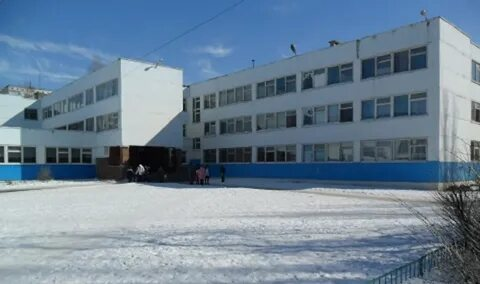

In [65]:
show_contains(data_filterd, 'Name', 'Школа № 33 имени Карла Маркса')

In [66]:
drop_names = ['Автомеханический техникум', 'Администрация Нижнего Новгорода',
              'Больница имени Н. В. Соловьёва', 'Нижегородское речное училище', 'Рекорд'
              'Школа № 33 имени Карла Маркса',
             ]

In [67]:
data_filterd = data_filterd[~data_filterd.Name.isin(drop_names)].reset_index(drop=True)
print(data_filterd.shape)
data_filterd.head(2)

(291, 16)


,Name,City,description,image,en_txt,en_description,all_en_txt,processed_text,unique_processed_text,num_tokens_of_all_en_txt,num_tokens_of_processed_text,num_tokens_of_unique_processed_text,prediction,len_Name,len_City,len_description
0,Cerkiew Narodzenia Pańskiego w Jarosławiu,Ярославль,Православный храм в Ярославле,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed wooden church with a steeple and a ste...,Orthodox Church in Yaroslavl,Orthodox Church in Yaroslavl arafed wooden chu...,orthodox church yaroslavl arafed wooden church...,dome orthodox blue crosses steeples flags larg...,265,130,30,5,41,9,29
1,Cerkiew Włodzimierskiej Ikony Matki Bożej w Ja...,Ярославль,Архитектурный ансамбль в Ярославле,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed wooden church with a steeple and a ste...,Architectural ensemble in Yaroslavl,Architectural ensemble in Yaroslavl arafed woo...,architectural ensemble yaroslavl arafed wooden...,snow roofing hill angels people chandelier rid...,653,322,96,5,54,9,34


SAVE = True
if SAVE:
    data_filterd.to_csv('data_filterd.csv', index=False)
else:
    data_filterd = pd.read_csv('data_filterd.csv')

Здесь предлагаем вам построить RAG с использованием моделей, которые не были представлены на семинаре (включая другие векторные базы данных). Можно воспользоваться материалами по этой ссылке: [data_connection/vectorstores](https://python.langchain.com/v0.1/docs/modules/data_connection/vectorstores/).

!Важно, не забудьте отранжировать чанки текстов с помощью `ragatouille`. На практике порядок текстов в промпте влияет на точность ответа.

In [68]:
# Передаем контент и метаинформацию в LangchainDocument

RAW_KNOWNLEDGE_BASE = [
    LangchainDocument(
        page_content=data_filterd["Name"][i] + ': ' + data_filterd["description"][i],
        metadata={"City": data_filterd["City"][i]
#                  , "image": data_filterd["image"][i]
                 })
    for i in tqdm(range(len(data_filterd)))
]

  0%|          | 0/291 [00:00<?, ?it/s]

In [69]:
# Мы используем иерархический список разделителей, специально предназначенных для разделения документов Markdown
# Этот список взят из класса MarkdownTextSplitter в LangChain

MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

CHUNK_SIZE = 512

TEXT_SPLITTER = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,  # Максимальное количество символов в чанке
    chunk_overlap=int(CHUNK_SIZE * 0.1),  # Количество символов, которые будут перекрываться между чанками
    add_start_index=True,  # Если "True", то включает начальный индекс чанка в метаданные
    strip_whitespace=True,  # Если значение "True", то пробелы удаляются из начала и конца каждого документа
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWNLEDGE_BASE:
    docs_processed += TEXT_SPLITTER.split_documents([doc])

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Model's maximum sequence length: 32768


  0%|          | 0/291 [00:00<?, ?it/s]

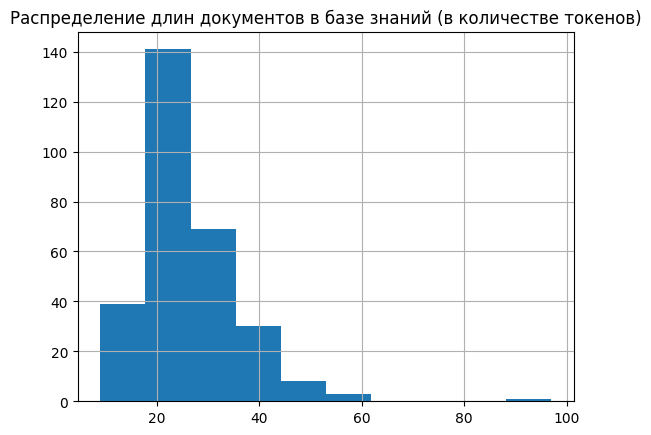

In [70]:
MODEL_NAME = "Qwen/Qwen2.5-1.5B-Instruct"

TOKENIZER = AutoTokenizer.from_pretrained(MODEL_NAME,
#                                          max_length=1024
                                         )

# Чтобы получить значение max sequence_length, мы запросим базовый объект `SentenceTransformer`, используемый в RecursiveCharacterTextSplitter
print(f"Model's maximum sequence length: {SentenceTransformer(MODEL_NAME).max_seq_length}")
lengths = [len(TOKENIZER.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Построим график распределения длин документов, подсчитываемых как количество токенов
fig = pd.Series(lengths).hist()
plt.title("Распределение длин документов в базе знаний (в количестве токенов)")
plt.show()

In [71]:
def create_embedding_model(model_name):
    """
    Функция создания ембеддинг модели
    """
    try:
        embedding_model = HuggingFaceEmbeddings(
            model_name=model_name,
            multi_process=True,
            model_kwargs={"device": "cuda"},
            encode_kwargs={"normalize_embeddings": True}, # `True` для косинусного сходства
        )

        print(f"Embedding model created")
        return embedding_model

    except Exception as e:
        print(f"Error creating embedding model: {str(e)}")
        return None

In [ ]:
%%time

EMBEDDING_MODEL = create_embedding_model(MODEL_NAME)
if EMBEDDING_MODEL:
    try:
        KNOWNLEDGE_VECTOR_DATABASE = Chroma.from_documents(docs_processed, EMBEDDING_MODEL)
        print(f"Vector database created")
    except Exception as e:
        print(f"Error creating vector database: {str(e)}")

In [ ]:
# Вставляем пользовательский запрос в то же пространство
user_query = "Что можно посмотреть в Екатеринбурге?"
query_vector = EMBEDDING_MODEL.embed_query(user_query)

In [ ]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWNLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=10)

print("\n==================================Топ похожих документов==================================")
for i in tqdm(range(len(retrieved_docs))):
    print(i, ' - '.join([retrieved_docs[i].metadata['City'],
                         retrieved_docs[i].page_content]))
    print('='*50)

In [ ]:
RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

print(f"\nStarting retrieval for {user_query=}...")
relevant_docs = [doc.page_content for doc in retrieved_docs]
relevant_docs = RERANKER.rerank(user_query, relevant_docs, k=5)

print("==================================Топ 1 проранжированный документ==================================")
print(relevant_docs[0])

In [ ]:
show_contains(data_filterd, 'Name', relevant_docs[0]['content'].split(':')[0])

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

MODELLLM = AutoModelForCausalLM.from_pretrained(MODEL_NAME,
                                                quantization_config=bnb_config)

READER_LLM = pipeline(
    model=MODELLLM,
    tokenizer=TOKENIZER,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500)

## Формирование промпта

Приведенный ниже шаблон RAG — это то, что мы передадим в Reader LLM: важно, чтобы он был отформатирован в шаблоне чата Reader LLM. Мы даем ему наш контекст и вопрос пользователя.

In [ ]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Ты чат бот ГИД, который помогает ориентироваться в городе,
а также рассказывает о местах и достопримечательностях в нем.
Используя информацию, содержащуюся в контексте, напиши краткий ответ на заданный вопрос.
Если ответ невозможно вывести из контекста скажи, что не знаешь.""",
    },
    {
        "role": "user",
        "content": """Контекст: {context} \n---
А теперь вопрос, на который вам нужно ответить.
Вопрос: {question}""",
    },
]


RAG_PROMPT_TEMPLATE = TOKENIZER.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

In [ ]:
relevant_docs_text = [doc['content'] for doc in relevant_docs]
context = "\nИзвлеченные документы:\n"
context += "".join([f"Документ {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs_text)])

final_prompt = RAG_PROMPT_TEMPLATE.format(question=user_query, context=context)

answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

In [ ]:
from transformers import Pipeline

def answer_with_rag(
    question: str,
    rag_prompt: str,
    llm: Pipeline,
    knowledge_index,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
    printing: bool=True
) -> Tuple[str, List[LangchainDocument]]:
    # Соберём документы с помощью ретривера
    if printing:
        print("=> Получение документов...")
    retrieved_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in retrieved_docs]

    if reranker:
        if printing:
            print("=> Ранжирование документов...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Финальный промпт
    context = "\nИзвлеченные документы:"
    context += " ".join([f"\nДокумент {str(i)}: " + doc for i, doc in enumerate(relevant_docs)])

    final_prompt = rag_prompt.format(question=question, context=context)
    if printing:
        print(f'Промт для RAG: \n\n{final_prompt}')
        print("=> Генерация ответа...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

### Проверим под каждый город

In [ ]:
%%time

QUESTION = "Какие места стоит посетить в Екатеринбурге?"

answer, relevant_docs = answer_with_rag(QUESTION, RAG_PROMPT_TEMPLATE, READER_LLM, KNOWNLEDGE_VECTOR_DATABASE, reranker=RERANKER)

print("==================================Ответ==================================\n")
print(f"{answer}")

In [ ]:
%%time

QUESTION = "Я в городе Ярославль, подскажи куда сходить?"

answer, relevant_docs = answer_with_rag(QUESTION, RAG_PROMPT_TEMPLATE, READER_LLM, KNOWNLEDGE_VECTOR_DATABASE, reranker=RERANKER)

print("==================================Ответ==================================\n")
print(f"{answer}")

In [ ]:
%%time

QUESTION = "Что посетить в Нижнем Новгороде?"

answer, relevant_docs = answer_with_rag(QUESTION, RAG_PROMPT_TEMPLATE, READER_LLM, KNOWNLEDGE_VECTOR_DATABASE, reranker=RERANKER)

print("==================================Ответ==================================\n")
print(f"{answer}")

In [ ]:
%%time

QUESTION = "Что посмотреть в городе Владимир?"

answer, relevant_docs = answer_with_rag(QUESTION, RAG_PROMPT_TEMPLATE, READER_LLM, KNOWNLEDGE_VECTOR_DATABASE, reranker=RERANKER)

print("==================================Ответ==================================\n")
print(f"{answer}")

Выполните визуализацию эмбеддингов при помощи метода главных компонент (PCA) и Uniform Manifold Approximation and Projection (UMAP). Пожалуйста, выполните PCA независимо от pacmap.

In [ ]:
pca_emb = PCA(n_components=2, random_state=42)

documents_projected = pca_emb.fit_transform(KNOWNLEDGE_VECTOR_DATABASE.get(include=["embeddings"])['embeddings'])

In [ ]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["City"],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Визуализируем эмбеддинги
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Источник чанка</b>",
    title="<b>2D-проекция вложений чанка с помощью PCA</b>",
)
fig.show()

In [ ]:
umap_emb = umap.UMAP(n_components=2, random_state=42)

documents_projected = umap_emb.fit_transform(KNOWNLEDGE_VECTOR_DATABASE.get(include=["embeddings"])['embeddings'])

In [ ]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["City"],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Визуализируем эмбеддинги
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Источник чанка</b>",
    title="<b>2D-проекция вложений чанка с помощью UMAP</b>",
)
fig.show()

# RAGAS (3 балла)

RAGAS - это система, созданная для автоматической оценки эффективности модели RAG. Она представляет собой комплексный инструмент, способный оценить как качество извлечения информации, так и качество созданного текста. Это достигается благодаря использованию различных метрик, которые анализируют разные аспекты ответов, сгенерированных языковой моделью.



## Метрики оценки в RAGAS

### Faithfulness
Оценивает, насколько ответы языковой модели верно передают информацию, содержащуюся в источниках данных. Это критически важно, чтобы гарантировать, что модель не искажает или не меняет информацию при её интерпретации.

---

$
Faithfulness = \frac{\text{|Number of claims that can be inferred from given context|}}{\text{|Total number of claims in the generated answer|}}
$

### Answer Relevancy
Демонстрирует, насколько ответы соответствуют заданным вопросам. Это важный аспект, так как даже правильный ответ с технической точки зрения может быть ненужным, если он не отвечает на конкретный вопрос пользователя.

---

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} cos(E_{g_i}, E_o)$

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} \frac{E_{g_i} \cdot E_o}{\|E_{g_i}\|\|E_o\|}$

Где:

* $E_{g_i}$ - это эмбеддинг сгенерированного ответа $i$

* $E_o$ - это эмбеддинг исходного вопроса.

* $N$ - это количество сгенерированных вопросов, которое по умолчанию равно 3.

### Context Recall и Context Precision
Эти метрики измеряют эффективность модели в учете контекста вопроса для формирования ответа. "Context Recall" оценивает количество использованной информации из контекста в ответе, в то время как "Context Precision" оценивает точность и релевантность использования контекстной информации.

---

* $ \text{context recall} = \frac{\text{|GT sentences that can be attributed to context|}}{\text{|Number of sentences in GT|}} $
* $Context Precision@k = \frac{\sum \text{precision@k}}{\text{total number of relevant items in the top K results}}$
  * $Precision@k = \frac{\text {true positives@k}}{\text{(true positives@k + false positives@k)}}$

### Answer Semantic Similarity
Оценивает степень семантической близости между ответом модели и эталонным ответом. Это позволяет определить, насколько естественно и точно модель способна воссоздавать человеческий язык.

### Answer Correctness
Оценка корректности ответа. Это последний шаг в проверке, чтобы убедиться, предоставляет ли модель точную и достоверную информацию в своем ответе.

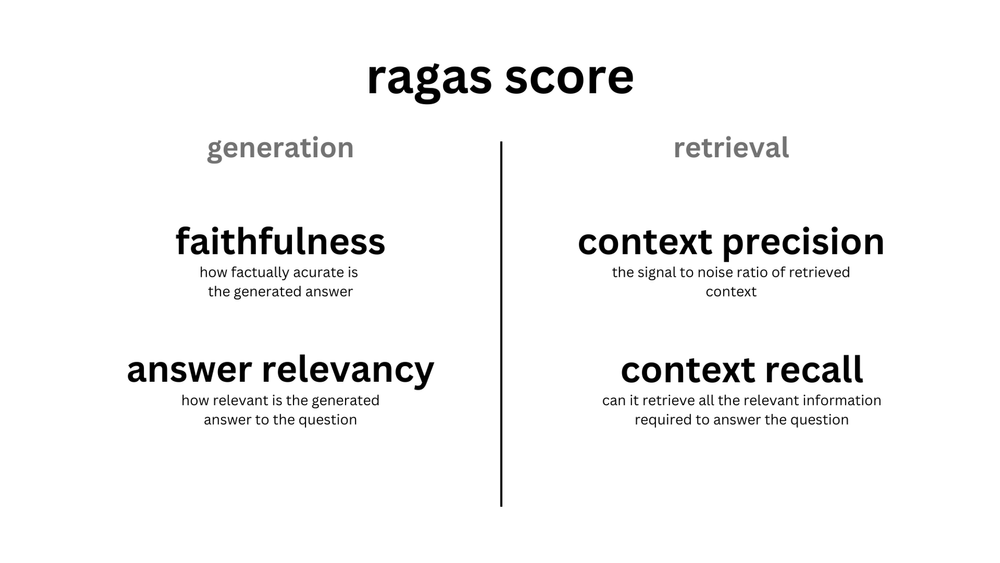

В этом задании вам нужно реализовать метрику answer_relevancy в коде. Опционально за допбаллы можно реализовать другие метрики.

Для этого датасет нужно привести к виду, в котором будут следующие поля:

### 1. question
- Смысл: Эта колонка содержит вопросы, на которые нужно найти ответы. В контексте задач QA, это основная информация, которую модель должна обработать для генерации ответа.
- Пример: "Каковы преимущества RAG?"

### 2. ground_truths
- Смысл: В этой колонке находятся правильные ответы на соответствующие вопросы. Это может использоваться для оценки производительности модели, так как позволяет сравнить сгенерированные ответы с эталонными.
- Пример: "RAG улучшает качество генерации, используя внешние источники информации."

### 3. answer
- Смысл: Эта колонка содержит ответы, которые генерирует модель на основе заданных вопросов. Это может быть результат работы модели, которую вы тестируете или обучаете.
- Пример: "RAG позволяет моделям извлекать информацию из внешних источников, что улучшает их способность отвечать на сложные вопросы."

### 4. contexts
- Смысл: Эта колонка предоставляет контекст или дополнительную информацию, которая может быть полезна для понимания вопроса или для формирования ответа. Это может быть текст, из которого был извлечен ответ, или другие релевантные документы.
- Пример: "RAG (Retrieval-Augmented Generation) — это метод, который использует внешние базы данных для получения информации при генерации текста."

HINT: Поле question можно тоже сгенерировать. Например, можно попросить модель задать вопрос по описанию изображения.

HINT: Для answer_relevancy нужны не все поля

HINT: Инференс такого эксперимента может быть долгим. План минимум: возьмите 100 случайных сэмплов.

In [ ]:
def data_preprocess(...):
  # your code here
  return ...

In [ ]:
def answer_relevancy(...):
  # your code here
  return ...

# Протестируйте ваш RAG (3 балла)

In [ ]:
# your code here

# Дополнительная часть (+3 балла)

Реализуйте одну из метрик retrieval-части на выбор.

Для того, чтобы понять model as a judge подход из RAGAS, советуем посетить [этот кукбук](https://huggingface.co/learn/cookbook/en/rag_evaluation)

In [ ]:
# your code here